# Task for Today  

***

## Marvel Character Image Classification  

Given *images of Marvel characters*, let's try to classifiy which **character** is present in a given image.

We will use a pretrained TensorFlow/Keras CNN to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('../input/marvel-heroes/marvel')

# Creating File DataFrame

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df['Label'].value_counts()

doctor strange     812
spider-man         766
captain america    762
thanos             756
hulk               754
black widow        750
ironman            748
loki               722
Name: Label, dtype: int64

In [4]:
samples = []
for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(200, random_state=1))
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

image_df['Label'].value_counts()

doctor strange     200
thanos             200
ironman            200
hulk               200
loki               200
captain america    200
black widow        200
spider-man         200
Name: Label, dtype: int64

In [5]:
image_df

,Filepath,Label
0,../input/marvel-heroes/marvel/marvel/train/lok...,loki
1,../input/marvel-heroes/marvel/marvel/train/iro...,ironman
2,../input/marvel-heroes/marvel/train/black wido...,black widow
3,../input/marvel-heroes/marvel/marvel/train/iro...,ironman
4,../input/marvel-heroes/marvel/train/doctor str...,doctor strange
...,...,...
1595,../input/marvel-heroes/marvel/train/thanos/pic...,thanos
1596,../input/marvel-heroes/marvel/marvel/train/hul...,hulk
1597,../input/marvel-heroes/marvel/train/spider-man...,spider-man
1598,../input/marvel-heroes/marvel/marvel/train/cap...,captain america


In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Loading Image Data

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 896 validated image filenames belonging to 8 classes.
Found 224 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.


# Training

In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False 

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
28/28 [==============================] - 28s 839ms/step - loss: 2.0481 - accuracy: 0.2376 - val_loss: 1.4806 - val_accuracy: 0.5000
Epoch 2/100
28/28 [==============================] - 15s 523ms/step - loss: 1.1945 - accuracy: 0.6085 - val_loss: 1.2022 - val_accuracy: 0.5982
Epoch 3/100
28/28 [==============================] - 16s 566ms/step - loss: 0.7555 - accuracy: 0.7563 - val_loss: 1.2578 - val_accuracy: 0.5714
Epoch 4/100
28/28 [==============================] - 15s 541ms/step - loss: 0.4435 - accuracy: 0.8838 - val_loss: 1.2186 - val_accuracy: 0.5848
Epoch 5/100
28/28 [==============================] - 15s 538ms/step - loss: 0.2926 - accuracy: 0.9365 - val_loss: 1.2280 - val_accuracy: 0.6384


# Results

Test Accuracy: 59.38%


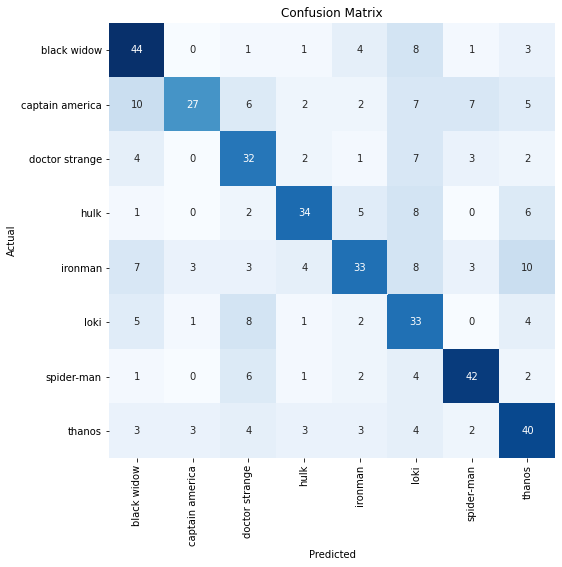

Classification Report:
----------------------
                  precision    recall  f1-score   support

    black widow       0.59      0.71      0.64        62
captain america       0.79      0.41      0.54        66
 doctor strange       0.52      0.63      0.57        51
           hulk       0.71      0.61      0.65        56
        ironman       0.63      0.46      0.54        71
           loki       0.42      0.61      0.50        54
     spider-man       0.72      0.72      0.72        58
         thanos       0.56      0.65      0.60        62

       accuracy                           0.59       480
      macro avg       0.62      0.60      0.59       480
   weighted avg       0.62      0.59      0.59       480



In [11]:
results = model.evaluate(test_images, verbose=0)
predictions = np.argmax(model.predict(test_images), axis=1)

class_names = list(test_images.class_indices.keys())

cm = confusion_matrix(test_images.labels, predictions, labels=np.arange(8))
clr = classification_report(test_images.labels, predictions, labels=np.arange(8), target_names=class_names)

print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [14]:
model.save('/kaggle/working/final_model2.h5')

In [15]:
import sys, os, multiprocessing, urllib3, csv
from PIL import Image
from io import BytesIO
from tqdm  import tqdm
import json

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def ParseData(data_file):
  key_url_list = []
  j = json.load(open(data_file))
  images = j['images']
  for item in images:
    url = item['url']
    id_ = item['id'].split('.')[0]
    extention = item['id'].split('.')[-1]
    if 'train' in data_file or 'val' in data_file:
        label = item['class']
        id_= "{}_{}".format(id_, label)
    key_url_list.append((id_, url, extention))
  return key_url_list

def DownloadImage(key_url):
  out_dir = sys.argv[2]
  (key, url,extention) = key_url
  filename = os.path.join(out_dir, key+'.'+extention)

  if os.path.exists(filename):
    print('Image %s already exists. Skipping download.' % filename)
    return

  try:
    #print('Trying to get %s.' % url)
    http = urllib3.PoolManager()
    response = http.request('GET', url)
    image_data = response.data
  except:
    print('Warning: Could not download image %s from %s' % (key, url))
    return

  try:
    pil_image = Image.open(BytesIO(image_data))
  except:
    print('Warning: Failed to parse image %s %s' % (key,url))
    return

  try:
    pil_image_rgb = pil_image.convert('RGB')
  except:
    print('Warning: Failed to convert image %s to RGB' % key)
    return

  try:
    pil_image_rgb.save(filename, format='JPEG', quality=90)
  except:
    print('Warning: Failed to save image %s' % filename)
    return


def Run():
  if len(sys.argv) != 3:
    print('Syntax: %s <train|val|test.json> <output_dir/>' % sys.argv[0])
    sys.exit(0)
  (data_file, out_dir) = sys.argv[1:]

  if not os.path.exists(out_dir):
    os.mkdir(out_dir)

  key_url_list = ParseData(data_file)
  pool = multiprocessing.Pool(processes=12)

  with tqdm(total=len(key_url_list)) as t:
    for _ in pool.imap_unordered(DownloadImage, key_url_list):
      t.update(1)


if __name__ == '__main__':
  Run()

FileNotFoundError: [Errno 2] No such file or directory: '-f'

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/p1znpVnjZKA